## Importing Libraries
To download all the required libraries, run the following pip command, also you can find a requirement.txt file for the same.

In [42]:
#pip install -r requirements.txt

In [40]:
# Data handling and preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import os

# TensorFlow and Keras for building models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# PyTorch and Transformers for BERT
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# Evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


## Exploration and Preprocesssing

In [43]:
# Uncomment Following code if executing on Google Colab Environment
# from google.colab import drive
# drive.mount('/content/drive')
# file_path = '/content/drive/My Drive/Problem_Dataset.csv'
# data = pd.read_csv(file_path)

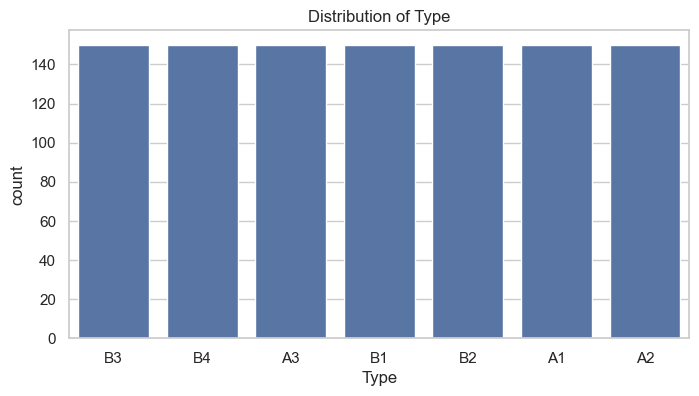

In [41]:
dataset_path = './Problem_Dataset.csv'
data = pd.read_csv(dataset_path)

# Distribution of 'Type' column
plt.figure(figsize=(8, 4))
sns.countplot(x='Type', data=data)
plt.title('Distribution of Type')
plt.show()


#### Each type (B3, B4, A3, B1, B2, A1, A2) has roughly the same count. This indicates that the dataset is balanced in terms of the number of samples for each type. there is no class imbalance.

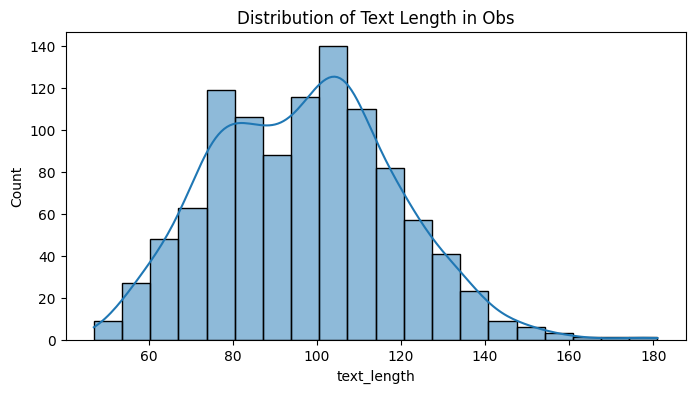

In [12]:
# Text length analysis
data['text_length'] = data['Obs'].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(data['text_length'], bins=20, kde=True)
plt.title('Distribution of Text Length in Obs')
plt.show()

#### This is a histogram with a kernel density estimate(KDE) line which shows bell shaped curve which shows a peak around 120 whixh tells that most of the samples are 120 charachters long, this information can be used to define sequence length

#### The Dataset is well balance as it has equal number of positive instances

In [13]:
# Parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

# Preprocessing the data
def preprocess_data(df):
    """
    Preprocessing the Input Data, here the function helps to tokenize the text,
    helps in padding our sentences sequence and splitrting it in Training sets and Validation Sets

    Parameters:
    df : The function takes df as argument on the preprocessing is meant to be done

    Returns:
    X_train : Training data which consists of padded sequence.
    X_val : Validation data which consists of padded sequence.
    y_train : Training labels with binary colums A1 to B4
    y_val : Validation labels with binary colums A1 to B4
    tokenizer : This is fitted tokenizer which will transfor the data as passed.
    """
    # During tokenization we need to limit number of unique words to be considered
    # initializing a tokenizer having maximum vocabulary size (which is defined globally)
    tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
    
    # Fitting it on Obs column of the dataset
    tokenizer.fit_on_texts(df['Obs'])
    # We will need to convert the text data into integers
    # here this method will assign an integer value
    sequences = tokenizer.texts_to_sequences(df['Obs'])
    
    # Pad sequences to ensure uniform input length
    X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Extract labels
    labels = df[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4']]
    
    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)
    
    return X_train, X_val, y_train, y_val, tokenizer

## Building a LSTM based Model
## Here LSTM model will be used as it is well-suited for handling and interpreting textual data.  LSTMs can process sequences of text in a way that considers the order of words, preserving the context throughout the sequence. Also it can handel sequences of varying lengths, which is crucial for NLP tasks where sentences or documents differ in length.

In [39]:
def build_model(input_length, vocab_size, num_labels):
    """
    This function is for building and compiling LSTM architecture based Model.

    Parameters:
    input_length : It defines the length of input sequence, number of words in each input
    vocab_size : It difines the number of unique words in data.
    num_labels (int): The number of labels or classes for the multi-label classification task.
    
    Return:
    model : returns a sequential model which can be further used for training.
    """

    # Initializing a sequential model
    model = Sequential()
    # Here embedding layer is used to convert each word into dense vector of fixed size.
    model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=input_length))
    # Using a LSTM model, here 128 refers to 128 neurons or LSTM units
    # Adding return_sequence as true to return full sequence as outputs for the following LSTM layer.
    model.add(LSTM(128, return_sequences=True))
    # To avoid overfitting, adding a dropout layer and dropping 20% of neurons.
    model.add(Dropout(0.2))
    # Here by default the input_sequence is false as only last output in the sequence is needed.
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(num_labels, activation='sigmoid'))
    # Using binary crossentropy loss function and adam optimizer
    # To update weights based on the loss.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Binary Classification Model

In [15]:
# Train models for each binary label
def train_binary_models(X_train, y_train, X_val, y_val, input_length, vocab_size,model_dir):
    """
    Trains binary classification models for each label in the dataset and saves them to disk.

    Parameters:
    X_train (np.ndarray): Training data consisting of padded sequences.
    y_train (pd.DataFrame): Training labels, where each column represents a binary label.
    X_val (np.ndarray): Validation data consisting of padded sequences.
    y_val (pd.DataFrame): Validation labels corresponding to binary columns in y_train.
    input_length (int): The length of the input sequences (number of words per sequence).
    vocab_size (int): The size of the vocabulary (number of unique words).
    model_dir (str): The directory where the trained models will be saved.

    Returns:
    models (dict): A dictionary where keys are label names and values are the corresponding trained models.
    """
    os.makedirs(model_dir, exist_ok=True)
    # Initializing an empty dictionary to save trained models for each label
    models = {}
    # Looping through each label in training data
    for label in y_train.columns:
        print(f"Training model for {label}...")
        model = build_model(input_length, vocab_size,1)
        # Train for 5 epochs
        # Stop training early if the validation loss doesn't improve for 2 consecutive epochs.
        model.fit(X_train, y_train[label], epochs=5, validation_data=(X_val, y_val[label]), 
                  callbacks=[EarlyStopping(patience=2)], batch_size=32)
        # # Save the trained model to disk in the specified directory.
        model.save(os.path.join(model_dir, f"{label}_model.h5"))  
        # Store the trained model in the `models` dictionary, using the label as the key.
        models[label] = model  
    return models

# Function to load models from the directory
def load_models(model_dir, labels):
    """
    Loads pre-trained binary classification models from disk.

    Parameters:
    model_dir (str): The directory where the trained models are stored.
    labels (list of str): A list of label names corresponding to the models to be loaded.

    Returns:
    models (dict): A dictionary where keys are label names and values are the corresponding loaded models.
    """
    models = {}
    for label in labels:
        model_path = os.path.join(model_dir, f"{label}_model.h5")
        models[label] = load_model(model_path)
    return models

## Ensemble Model

In [16]:
def predict_ensemble(models, X):
    """
    Generates ensemble predictions from multiple binary classification models.

    Parameters:
    models (dict): A dictionary where keys are label names and values are trained models.
    X (np.ndarray): The input data on which predictions will be made.

    Returns:
    final_predictions (np.ndarray): A 2D array with binary predictions (0 or 1) for each label.
    """
    ensemble_predictions = np.zeros((X.shape[0], len(models))) 
    # Loop through each model and its corresponding label.
    for i, (label, model) in enumerate(models.items()):
        # Make predictions using the model for the current label.
        # Also using squeeze() to make sure predictions are 1D
        preds = model.predict(X).squeeze()  
        ensemble_predictions[:, i] = preds  
    # Convert the ensemble predictions to binary (0 or 1) based on a threshold of 0.5.
    final_predictions = (ensemble_predictions >= 0.5).astype(int)
    
    return final_predictions

# Calculate metrics for each label
def calculate_metrics(final_predictions, y_true, labels):
    """
    Calculates precision, recall, and F1-score for each label.

    Parameters:
    final_predictions (np.ndarray): The predicted binary labels.
    y_true (pd.DataFrame): The true labels corresponding to each label.
    labels (list of str): The list of label names.

    Returns:
    metrics (dict): A dictionary where each label has a sub-dictionary with precision, recall, and F1-score.
    """
    metrics = {}
    # Loop through each label and its corresponding index.
    for i, label in enumerate(labels):
        y_pred = final_predictions[:, i]
        y_actual = y_true[label].values
        precision = precision_score(y_actual, y_pred)
        recall = recall_score(y_actual, y_pred)
        f1 = f1_score(y_actual, y_pred)
        metrics[label] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    return metrics


def save_metrics(metrics, file_path):
    """
    Save the provided metrics dictionary to a CSV file.

    Parameters:
    - metrics (dict): A dictionary where each key is a label, and each value is another dictionary
      containing metric names and their corresponding values.
    
    - file_path (str): The path to the CSV file where the DataFrame will be saved.
      Example: "output/metrics.csv"

    Returns:
    - None: The function does not return any value. It writes the metrics data to a CSV file specified by `file_path`.
    """
    # Prepare data for DataFrame
    data = []
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            data.append([label, metric_name, value])
    
    # Create a DataFrame
    df = pd.DataFrame(data, columns=["Label", "Metric", "Value"])
    
    # Save DataFrame to CSV
    df.to_csv(file_path, index=False)

# Save predictions to a CSV file
def save_predictions(predictions, original_data, labels, file_path):
    """
    Saves the ensemble predictions to a CSV file.

    Parameters:
    predictions (np.ndarray): The binary predictions generated by the ensemble.
    original_data (pd.DataFrame): The original data containing columns like 'sID' and 'Obs'.
    labels (list of str): The list of label names corresponding to the predictions.
    file_path (str): The file path where the predictions will be saved.

    Returns:
    None
    """
    pred_df = pd.DataFrame(predictions, columns=labels)
    results_df = pd.concat([original_data[['sID', 'Obs']], pred_df], axis=1)
    results_df.to_csv(file_path, index=False)


# Main function to load models, make predictions, and evaluate
def main(model_dir, X_val, y_val, labels, metrics_output_file, predictions_output_file):
    """
    Main function to load models, make predictions, evaluate, and save results.

    Parameters:
    model_dir (str): The directory where the trained models are stored.
    X_val (np.ndarray): The validation data on which predictions will be made.
    y_val (pd.DataFrame): The true validation labels.
    labels (list of str): The list of label names.
    metrics_output_file (str): The file path to save the evaluation metrics.
    predictions_output_file (str): The file path to save the predictions.

    Returns:
    final_predictions (np.ndarray): The binary predictions generated by the ensemble.
    metrics (dict): The calculated precision, recall, and F1-score for each label.
    """
    # Load the models
    models = load_models(model_dir, labels)
    
    # Predict using ensemble
    final_predictions = predict_ensemble(models, X_val)
    
    # Calculate precision, recall, and F1-score
    metrics = calculate_metrics(final_predictions, y_val, labels)
    
    # Save metrics to a file
    save_metrics(metrics, metrics_output_file)
    
    # Save predictions to a file
    save_predictions(final_predictions, df, labels, predictions_output_file)
    
    return final_predictions, metrics

# Define labels
labels = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4']

dataset_path = './Problem_Dataset.csv'
df = pd.read_csv(dataset_path)

# Preprocess the data
X_train, X_val, y_train, y_val, tokenizer = preprocess_data(df)

# Directory where models should be saved
model_dir = './Ensemble/Models'

# Train binary classification models
binary_models = train_binary_models(X_train, y_train, X_val, y_val, X_train.shape[1], len(tokenizer.word_index) + 1, model_dir)

# Output files to save metrics and predictions
metrics_output_file = './Ensemble/metrics.csv'
predictions_output_file = './Ensemble/ensemble_predictions.csv'

# Evaluate the ensemble models and save predictions
final_predictions, ensemble_metrics = main(model_dir, X_val, y_val, labels, metrics_output_file, predictions_output_file)

# Display metrics
for label, metric in ensemble_metrics.items():
    print(f"{label} metrics:")
    print(f"  Precision: {metric['precision']:.4f}")
    print(f"  Recall:    {metric['recall']:.4f}")
    print(f"  F1-Score:  {metric['f1_score']:.4f}\n")

Training model for A1...


c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7731 - loss: 0.5464 - val_accuracy: 0.8619 - val_loss: 0.4066
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8495 - loss: 0.4270 - val_accuracy: 0.8619 - val_loss: 0.3945
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8411 - loss: 0.4193 - val_accuracy: 0.8810 - val_loss: 0.3400
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.8991 - loss: 0.2623 - val_accuracy: 0.9190 - val_loss: 0.2082
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9492 - loss: 0.1460 - val_accuracy: 0.9000 - val_loss: 0.2883


Training model for A2...
Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8383 - loss: 0.5262 - val_accuracy: 0.8762 - val_loss: 0.3696
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8557 - loss: 0.4012 - val_accuracy: 0.8905 - val_loss: 0.2622
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9218 - loss: 0.2156 - val_accuracy: 0.9429 - val_loss: 0.1680
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9373 - loss: 0.1415 - val_accuracy: 0.9429 - val_loss: 0.2037
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9744 - loss: 0.0761 - val_accuracy: 0.9476 - val_loss: 0.2083


Training model for A3...
Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8186 - loss: 0.5148 - val_accuracy: 0.8524 - val_loss: 0.4170
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8651 - loss: 0.4011 - val_accuracy: 0.8524 - val_loss: 0.4100
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8648 - loss: 0.3808 - val_accuracy: 0.9048 - val_loss: 0.2423
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9027 - loss: 0.2022 - val_accuracy: 0.9143 - val_loss: 0.2307
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9562 - loss: 0.1173 - val_accuracy: 0.9143 - val_loss: 0.2602


Training model for B1...
Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8077 - loss: 0.5159 - val_accuracy: 0.8333 - val_loss: 0.4512
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8387 - loss: 0.4523 - val_accuracy: 0.8333 - val_loss: 0.4732
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8679 - loss: 0.4051 - val_accuracy: 0.8333 - val_loss: 0.4426
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8641 - loss: 0.3699 - val_accuracy: 0.8857 - val_loss: 0.2286
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9533 - loss: 0.1295 - val_accuracy: 0.9619 - val_loss: 0.1213


Training model for B2...
Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7773 - loss: 0.5270 - val_accuracy: 0.8762 - val_loss: 0.2987
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9026 - loss: 0.2402 - val_accuracy: 0.9333 - val_loss: 0.1764
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9774 - loss: 0.0598 - val_accuracy: 0.9571 - val_loss: 0.1344
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9973 - loss: 0.0145 - val_accuracy: 0.9524 - val_loss: 0.1498
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9984 - loss: 0.0109 - val_accuracy: 0.9714 - val_loss: 0.1249


Training model for B3...
Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8461 - loss: 0.5023 - val_accuracy: 0.8286 - val_loss: 0.4623
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8666 - loss: 0.3893 - val_accuracy: 0.8286 - val_loss: 0.4502
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8543 - loss: 0.4133 - val_accuracy: 0.8286 - val_loss: 0.3864
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8914 - loss: 0.2557 - val_accuracy: 0.9190 - val_loss: 0.2064
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9542 - loss: 0.1134 - val_accuracy: 0.9381 - val_loss: 0.2173


Training model for B4...
Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8045 - loss: 0.5326 - val_accuracy: 0.8714 - val_loss: 0.3841
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8500 - loss: 0.4237 - val_accuracy: 0.8714 - val_loss: 0.3805
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8631 - loss: 0.3888 - val_accuracy: 0.8714 - val_loss: 0.2792
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9344 - loss: 0.1762 - val_accuracy: 0.9476 - val_loss: 0.1197
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9733 - loss: 0.0647 - val_accuracy: 0.9857 - val_loss: 0.0533


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
A1 metrics:
  Precision: 0.7222
  Recall:    0.4483
  F1-Score:  0.5532

A2 metrics:
  Precision: 0.8571
  Recall:    0.6923
  F1-Score:  0.7660

A3 metrics:
  Precision: 0.6857
  Recall:    0.7742
  F1-Score:  0.7273

B1 metrics:
  Precision: 0.9355
  Recall:    0.8286
  F1-Score:  0.8788

B2 metrics:
  Precision: 0.9167
  Recall:    0.8462
  F1-Score:  0.8800

B3 metrics:
  Precision: 0.9600
  Recall:    0.6667
  F1-Score:  0.7869

B4 metrics:
  Precision: 0.9000
  Recall:    1.0000
  F1-Score:  0.9474



## Multi-Label Classification Model

In [36]:
def train_multi_label_model(X_train, y_train, X_val, y_val, input_length, vocab_size, MultiModel_dir):
    """
    Train a multi-label classification model using the provided training and validation data.

    Parameters:
    X_train (numpy.ndarray): The training input data,  array of sequences.
    y_train (numpy.ndarray): The training labels, array where each row corresponds to a multi-label binary vector.
    X_val (numpy.ndarray): The validation input data, used to evaluate the model during training.
    y_val (numpy.ndarray): The validation labels, used to assess the model's performance during training.
    input_length (int): The length of the input sequences, defining the number of words in each input sequence.
    vocab_size (int): The size of the vocabulary, i.e., the number of unique tokens or words in the input data.
    MultiModel_dir (str): The directory path where the trained model will be saved.

    Returns:
    model : The trained Sequential model.
    """
    os.makedirs(MultiModel_dir, exist_ok=True)
    num_labels = y_train.shape[1]
    # Build the model
    model = build_model(input_length, vocab_size, num_labels)
    
    print("Training multi-label model...")
    model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), 
              callbacks=[EarlyStopping(patience=2)], batch_size=32, verbose =1)
    # Save the trained model to the specified directory
    model.save(os.path.join(MultiModel_dir, "multi_label_model.h5")) 
    return model

def predict_multi_label_model(model, X):
    """
    Generate binary predictions from a multi-label classification model.

    Parameters:
    model : The trained model used for making predictions.
    X (numpy.ndarray): The input data for which predictions are to be made. This is a 2D array of sequences.

    Returns:
    final_predictions (numpy.ndarray): A 2D array of binary predictions (0 or 1) for each label.
    """
    # Predict probabilities for each label
    predictions = model.predict(X)
    # Convert probabilities to binary predictions
    final_predictions = (predictions >= 0.4).astype(int)
    return final_predictions

def calculate_multi_label_metrics(final_predictions, y_true):
    """
    Calculate precision, recall, and F1 score for each label in a multi-label classification task.

    Parameters:
    final_predictions (numpy.ndarray): The binary predictions generated by the model, a 2D array where each column corresponds to a label.
    
    y_true (pandas.DataFrame): The true labels for the dataset, where each column represents a label.

    Returns:
    metrics (dict): A dictionary containing precision, recall, and F1 score for each label.
    """
    metrics = {}
    for i, label in enumerate(y_true.columns):
        y_pred = final_predictions[:, i]
        y_actual = y_true[label].values
        precision = precision_score(y_actual, y_pred)
        recall = recall_score(y_actual, y_pred)
        f1 = f1_score(y_actual, y_pred)
        metrics[label] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    return metrics

def save_multi_label_metrics(metrics, file_path):
    """
    Save the provided metrics dictionary to a CSV file.

    Parameters:
    - metrics (dict): A dictionary where each key is a label, and each value is another dictionary
      containing metric names and their corresponding values.
    
    - file_path (str): The path to the CSV file where the DataFrame will be saved.
      Example: "output/metrics.csv"

    Returns:
    - None: The function does not return any value. It writes the metrics data to a CSV file specified by `file_path`.
    """
    # Prepare data for DataFrame
    data = []
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            data.append([label, metric_name, value])
    
    # Create a DataFrame
    df = pd.DataFrame(data, columns=["Label", "Metric", "Value"])
    
    # Save DataFrame to CSV
    df.to_csv(file_path, index=False)

def save_multi_label_predictions(predictions, original_data, labels, file_path):
    """
    Save the multi-label predictions alongside original data to a CSV file.

    Parameters:
    predictions (numpy.ndarray): A 2D array of binary predictions (0 or 1) for each label.   
    original_data (pandas.DataFrame): The original dataset, which includes columns such as 'sID' and 'Obs'.
    labels (list): A list of label names corresponding to the columns in the predictions array.
    file_path (str): The path to the CSV file where the predictions and original data will be saved.

    Returns:
    - None: This function does not return any value. It writes the predictions and original data to a CSV file.
    """
    pred_df = pd.DataFrame(predictions, columns=labels)
    results_df = pd.concat([original_data[['sID', 'Obs']], pred_df], axis=1)
    results_df.to_csv(file_path, index=False)


In [37]:
def Multimain(model_dir, X_train, y_train, X_val, y_val, labels, metrics_output_file, predictions_output_file):
    """
    Train a multi-label model, evaluate its performance, and save the results.

    Parameters:
    model_dir (str): Directory where the trained model will be saved.
    X_train (numpy.ndarray): The training input data, a 2D array of sequences.
    y_train (numpy.ndarray): The training labels, a 2D array where each row corresponds to a multi-label binary vector.
    X_val (numpy.ndarray): The validation input data, used to evaluate the model during training.
    y_val (numpy.ndarray): The validation labels, used to assess the model's performance during training.
    labels (list): A list of label names corresponding to the columns in the predictions array.
    metrics_output_file (str): The path to the file where the calculated metrics will be saved.
    predictions_output_file (str): The path to the file where the predictions will be saved.

    Returns:
    final_predictions (numpy.ndarray): A 2D array of binary predictions (0 or 1) for each label.
    metrics (dict): A dictionary containing precision, recall, and F1 score for each label.
    """
    # Train the model
    model = train_multi_label_model(X_train, y_train, X_val, y_val, X_train.shape[1], len(tokenizer.word_index) + 1, MultiModel_dir)
    
    # Predict using the trained model
    final_predictions = predict_multi_label_model(model, X_val)
    
    # Calculate precision, recall, and F1-score
    metrics = calculate_multi_label_metrics(final_predictions, y_val)
    
    # Save metrics to a file
    save_multi_label_metrics(metrics, metrics_output_file)
    
    # Save predictions to a file
    save_multi_label_predictions(final_predictions, df, labels, predictions_output_file)
    
    return final_predictions, metrics

# Define labels
labels = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4']

dataset_path = './Problem_Dataset.csv'
df = pd.read_csv(dataset_path)

# Preprocess the data
X_train, X_val, y_train, y_val, tokenizer = preprocess_data(df)

# Directory where models should be saved
MultiModel_dir = './MultiModel/Models'

# Output files to save metrics and predictions
metrics_output_file = './MultiModel/metrics.csv'
predictions_output_file = './MultiModel/multi_predictions.csv'

# Evaluate the multi-label model and save predictions
final_predictions, multi_label_metrics = Multimain(MultiModel_dir, X_train, y_train, X_val, y_val, labels, metrics_output_file, predictions_output_file)

# Display metrics
for label, metric in multi_label_metrics.items():
    print(f"{label} metrics:")
    print(f"  Precision: {metric['precision']:.4f}")
    print(f"  Recall:    {metric['recall']:.4f}")
    print(f"  F1-Score:  {metric['f1_score']:.4f}\n")



c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training multi-label model...
Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.1359 - loss: 0.5455 - val_accuracy: 0.1381 - val_loss: 0.4112
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.1443 - loss: 0.4175 - val_accuracy: 0.1238 - val_loss: 0.4111
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.1607 - loss: 0.4164 - val_accuracy: 0.1286 - val_loss: 0.4108
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.1084 - loss: 0.4199 - val_accuracy: 0.1667 - val_loss: 0.4083
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.1943 - loss: 0.4074 - val_accuracy: 0.2667 - val_loss: 0.3824
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2778 - loss: 0.3741 - val_accuracy: 0.3095 - val_loss: 0.3444
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.3897 - loss: 0.3264 - val_accuracy: 0.3571 - val_loss: 0.3189
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.4258 - loss: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
A1 metrics:
  Precision: 0.4375
  Recall:    0.7241
  F1-Score:  0.5455

A2 metrics:
  Precision: 0.7778
  Recall:    0.2692
  F1-Score:  0.4000

A3 metrics:
  Precision: 0.4583
  Recall:    0.7097
  F1-Score:  0.5570

B1 metrics:
  Precision: 0.8000
  Recall:    0.6857
  F1-Score:  0.7385

B2 metrics:
  Precision: 0.8800
  Recall:    0.8462
  F1-Score:  0.8627

B3 metrics:
  Precision: 0.7895
  Recall:    0.8333
  F1-Score:  0.8108

B4 metrics:
  Precision: 0.7879
  Recall:    0.9630
  F1-Score:  0.8667



## BERT Transformer

In [20]:
# Load the dataset
file_path = './Problem_Dataset.csv'
df = pd.read_csv(file_path)

# Preprocessing
sentences = df['Obs'].values
labels = df[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4']].values

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)


#### Here, a custom dataset is to be made which inherits from torch.utils.data.Dataset, which is an abstract class that PyTorch uses to load data. By creating a custom dataset, we can ensure that data is structured and processed in a way that the model can work with.

In [21]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        # Initialize with texts, labels, tokenizer, and max_len parameters
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.texts)

    def __getitem__(self, idx):
        # For a given index, retrieve the corresponding text and label
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text using the tokenizer provided
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False, # Not needed for classification
            padding='max_length',
            truncation=True,
            return_attention_mask=True, # Returning Attention Mask
            return_tensors='pt',
        )
        # Return the text, input_ids, attention_mask, and labels as a dictionary
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [22]:
# Initialize the BERT tokenizer using the 'bert-base-uncased' model
# The 'bert-base-uncased' tokenizer converts the input text into tokens compatible with the BERT model.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128
batch_size = 16

# Create data loaders for training and validation
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)

# Define the device: Use GPU if available, otherwise use CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move the model to the appropriate device
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Training loop
epochs = 5

for epoch in range(epochs):
    # This will train the model
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # To clear previous gradients
        optimizer.zero_grad()

        # compute the model output given the inputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # The model's loss is calculated based on the output logits and the true labels
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    # Calculate the average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')

# Validation
model.eval()
val_predictions, val_true_labels = [], []

# Here we can save memory by diabling gradient computation
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        val_predictions.append(logits)
        val_true_labels.append(labels)

# Convert predictions to binary labels
# We will apply sigmoid to obtain binary predictions
predicted_labels = (torch.sigmoid(torch.cat(val_predictions)) > 0.5).int()
true_labels = torch.cat(val_true_labels).int()

# Calculate accuracy, precision, recall, f1-score on the validation set
accuracy = accuracy_score(true_labels.cpu(), predicted_labels.cpu())
precision, recall, f1, _ = precision_recall_fscore_support(true_labels.cpu(), predicted_labels.cpu(), average='weighted')

print(f'Validation Accuracy: {accuracy}')
print(f'Validation Precision: {precision}')
print(f'Validation Recall: {recall}')
print(f'Validation F1-Score: {f1}')

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be rename

Epoch 1/5, Loss: 0.383330392387678
Epoch 2/5, Loss: 0.20846874702651547
Epoch 3/5, Loss: 0.13541794919742728
Epoch 4/5, Loss: 0.08849201245971446
Epoch 5/5, Loss: 0.06384083790318021
Validation Accuracy: 0.8
Validation Precision: 0.836884396965042
Validation Recall: 0.8095238095238095
Validation F1-Score: 0.8182893412048996


In [25]:
# Calculate metrics for each label
metrics_data = []
label_names = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4']

for i, label_name in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels.cpu()[:, i], predicted_labels.cpu()[:, i], average='binary')
    metrics_data.append([label_name, 'precision', precision])
    metrics_data.append([label_name, 'recall', recall])
    metrics_data.append([label_name, 'f1_score', f1])

# Convert metrics data to DataFrame and save as CSV
metrics_df = pd.DataFrame(metrics_data, columns=['Label', 'Metric', 'Value'])
metrics_df.to_csv('BERT/label_metrics.csv', index=False)

# Save the predictions in the desired format
predictions_df = pd.DataFrame(predicted_labels.cpu().numpy(), columns=label_names)
predictions_df.insert(0, 'Obs', val_texts)  # Insert the original observations back into the DataFrame
predictions_df.to_csv('BERT/predictions.csv', index=False)

In [24]:
model_save_path = 'BERT/Model/model_state_dict.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model state dictionary saved to {model_save_path}')

# Save the entire model
full_model_save_path = 'BERT/Model/full_model.pth'
torch.save(model, full_model_save_path)
print(f'Entire model saved to {full_model_save_path}')

Model state dictionary saved to BERT/Model/model_state_dict.pth
Entire model saved to BERT/Model/full_model.pth


## Comparision

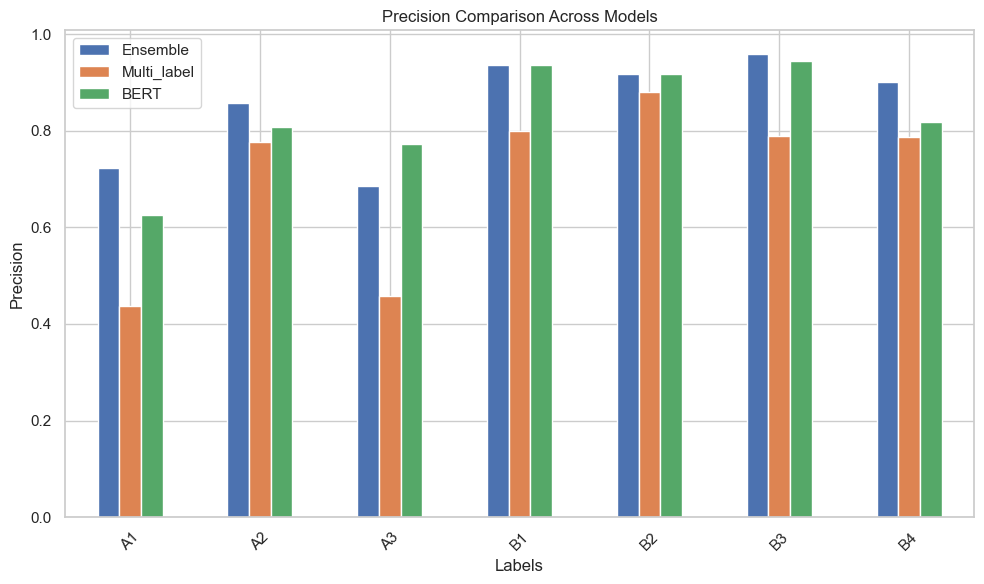

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files into dataframes
ensemble_df = pd.read_csv('Ensemble/metrics.csv')
multi_label_df = pd.read_csv('MultiModel/metrics.csv')
bert_df = pd.read_csv('BERT/label_metrics.csv')

# Rename the 'Value' column to indicate the model
ensemble_df.rename(columns={'Value': 'Ensemble'}, inplace=True)
multi_label_df.rename(columns={'Value': 'Multi_label'}, inplace=True)
bert_df.rename(columns={'Value': 'BERT'}, inplace=True)

# Merge the dataframes on 'Label' and 'Metric'
merged_df = pd.merge(ensemble_df, multi_label_df, on=['Label', 'Metric'])
merged_df = pd.merge(merged_df, bert_df, on=['Label', 'Metric'])

# Pivot the dataframe
pivot_df = merged_df.pivot(index='Label', columns='Metric')

# Plotting Precision
precision_df = pivot_df.xs('precision', axis=1, level=1)
precision_df.plot(kind='bar', figsize=(10, 6))
plt.title('Precision Comparison Across Models')
plt.ylabel('Precision')
plt.xlabel('Labels')
plt.xticks(rotation=45)
plt.legend(['Ensemble', 'Multi_label', 'BERT'])
plt.tight_layout()
plt.show()


#### Precision tells us about measure of positive predictions i.e the instances that were correctly identified positive out of all the positive instance. This is very crucial in situations where cost of false positives is high.
#### In our case, Ensemble model has the highest precision across most labels. But particularly for B labels BERT surpassed other models, which shows in certain context BERT is performing better.
#### There is a variable performance for Multi Label Model, as it has highest for A2 but lower for others
#### In contexts where precision is critical, the Ensemble model generally performs best, with the BERT model also showing strong performance, particularly for the B-labels. 

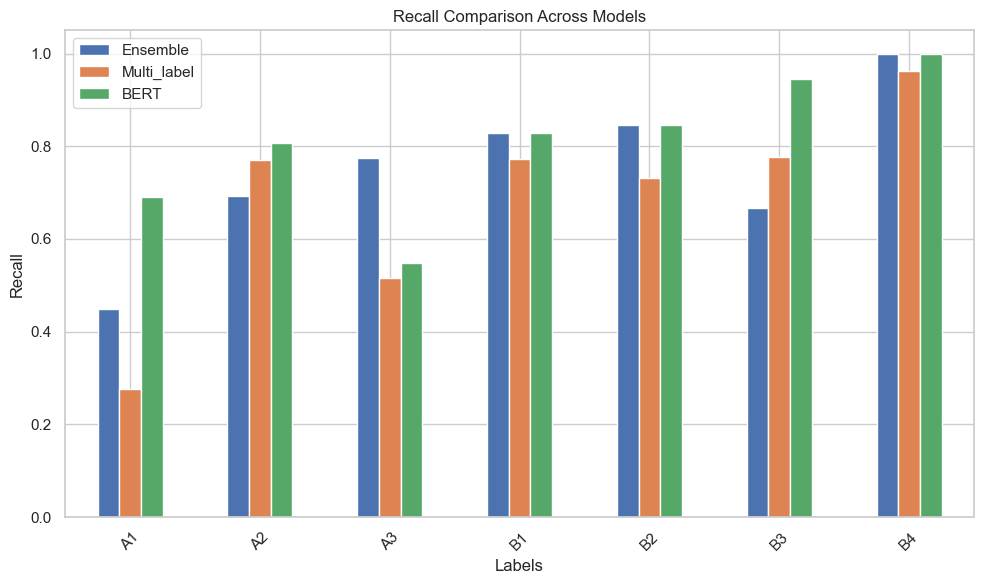

In [33]:
# Plotting Recall
recall_df = pivot_df.xs('recall', axis=1, level=1)
recall_df.plot(kind='bar', figsize=(10, 6))
plt.title('Recall Comparison Across Models')
plt.ylabel('Recall')
plt.xlabel('Labels')
plt.xticks(rotation=45)
plt.legend(['Ensemble', 'Multi_label', 'BERT'])
plt.tight_layout()
plt.show()

#### Recall measures the ability of the model to correctly identify all positive instances. It is the ratio of true positives (correctly predicted positive instances) to the total actual positives (true positives + false negatives).
#### High Recall Indicates that the model successfully identified most of the actual positive cases. This is particularly important in situations where missing positive instances would be costly.
#### In our case BERT Consistently had high recall across all the labels especially strong in A1, A2, B1, B2, and B3. 
#### Ensemble performed well with A3 and B4 labels compared to BERT
#### Multi Label have more tendency for missing more positives that the other models



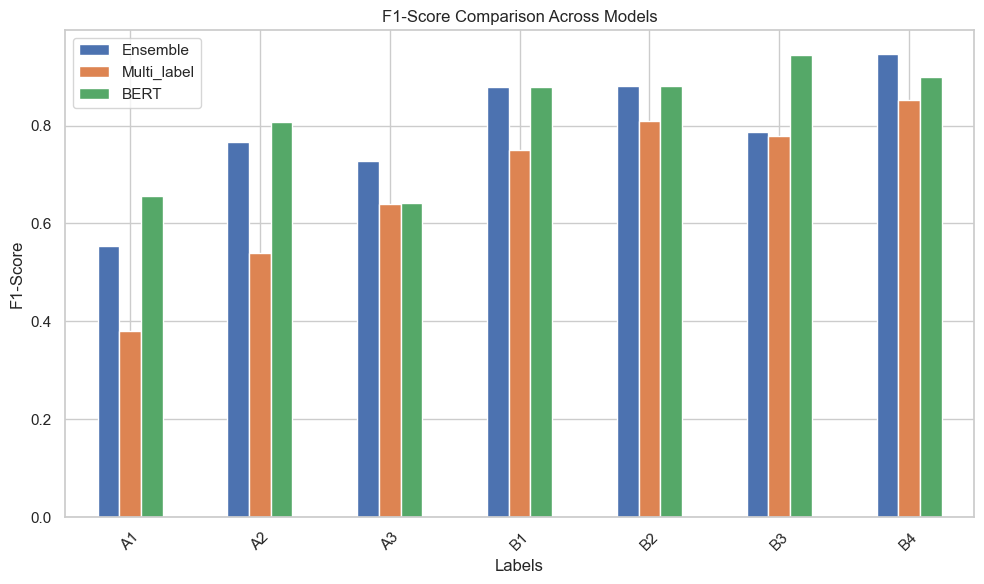

In [34]:
# Plotting F1-Score
f1_score_df = pivot_df.xs('f1_score', axis=1, level=1)
f1_score_df.plot(kind='bar', figsize=(10, 6))
plt.title('F1-Score Comparison Across Models')
plt.ylabel('F1-Score')
plt.xlabel('Labels')
plt.xticks(rotation=45)
plt.legend(['Ensemble', 'Multi_label', 'BERT'])
plt.tight_layout()
plt.show()

#### The F1 score is the harmonic mean of precision and recall
#### F1 Score = (2*Precision*Recall)/(Precision+Recall)
#### This means the F1 score provides a single metric that balances both precision and recall, making it useful when you need a balance between them, especially in situations where one is more important than the other.
#### In our case, BERT has the highest F1 Score among all the labels as compared to other models.
#### Ensemble also have a good F1 Score which tells that it is also a good model.
#### Multi label has potential challenges in balancing precision and recall comapred to other models.

## Summary

#### Precision measures the accuracy of positive predictions, crucial when the cost of false positives is high. The Ensemble model generally has the highest precision across most labels, with BERT outperforming in B-labels, indicating its strength in specific contexts. The Multi Label model shows variable performance, excelling in A2 but underperforming in others.

#### Recall assesses the model's ability to identify all positive instances. BERT consistently achieves high recall across most labels, particularly strong in A1, A2, B1, B2, and B3. The Ensemble model performs well with A3 and B4, while the Multi Label model tends to miss more positives compared to others.

#### F1 Score, the harmonic mean of precision and recall, balances both metrics. BERT has the highest F1 Score across all labels, suggesting overall better performance in balancing precision and recall. The Ensemble model also shows a good F1 Score, indicating strong performance. The Multi Label model faces challenges in maintaining this balance compared to the other models.

#### In summary, BERT excels in recall and F1 Score, particularly for B-labels and certain A-labels. The Ensemble model shows high precision and good F1 Score, performing well across most labels. The Multi Label model struggles with balancing precision and recall but performs well in specific instances.